In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
def poset_order_ideals_iter(pset):
    return (Set(pset.order_ideal(antichain)) for antichain in pset.antichains_iterator())

In [3]:
def chain_poset_coord_to_xyz(c):
    return (c[0][0], c[1], c[0][1])


def xyz_to_chain_poset_coord(c):
    return ((c[0], c[2]), c[1])


def chain_poset_oi_to_xyz_oi(oi):
    r"""
    Takes an iterable of points of the form ((x,z),y) and returns
    a Set of the same points, formatted as (x, y, z)
    """
    return Set([chain_poset_coord_to_xyz(c) for c in oi])


def xyz_oi_to_chain_poset_oi(oi):
    r"""
    Takes an iterable of points of the form (x, y, z) and returns
    a Set of the same points, formatted as ((x,z), y)
    """
    return Set([xyz_to_chain_poset_coord(c) for c in oi])


def oi_to_tableau(oi):
    """
    Construct a tableau representation of an order ideal.
    
    oi is an iterable of points (x,y,z) that form an order ideal.
    
    Returns a tableau as a list of lists T, where T[i][j] is the
    highest value of z with x = i and y = j.
    """
    from collections import defaultdict
    d = defaultdict(int)
    for x, y, z in oi:
        if z + 1 > d[(x,y)]:
            d[(x,y)] = z + 1
    mat = Matrix(d)
    return [row.list() for row in mat]


def squarify(M, val):
    """Make a numpy.matrix `M` square by padding with `val`"""
    import numpy
    (a, b) = M.shape
    if a > b:
        padding = ((0, 0), (0, a - b))
    else:
        padding = ((0, b - a), (0, 0))
    return numpy.pad(M, padding, mode='constant', constant_values=val)


def symmetrize_matrix(M):
    """
    Symmetrize a numpy matrix `M` about its main diagonal.

    `M` can be either upper or lower triangular.
    """
    import numpy
    square = squarify(M, 0)
    return numpy.maximum(square, square.transpose())


def symmetrize_tableau(tab):
    """
    Symmetrize a tableau (as a list of lists) about its main diagonal.

    The tableau need not be square, and can be upper or lower triangular.
    """
    import numpy
    M = numpy.matrix(tab)
    sym = symmetrize_matrix(M)
    return sym.tolist()


def oi_to_symmetric_plane_partition(oi):
    tab = oi_to_tableau(oi)
    tab = symmetrize_tableau(tab)

    return PlanePartition(tab)


def oi_to_plane_partition(oi, symmeterize=False):
    r"""
    Returns the PlanePartition representation of oi.
    
    oi is an iterable of 3D coordinates of the form (x, y, z)
    symmeterize specifies whether or not to symmeterize the 
    coordinates over the x=y plane. 
    
    """
    tab = oi_to_tableau(oi)
    return PlanePartition(tab)


def chain_poset_oi_to_plane_partition(oi):
    r"""
    Takes on order ideal from a product of chains poset as an iterable
    of points of the form ((x,z), y) and returns the PlanePartition formed
    by those points
    """
    i = chain_poset_oi_to_xyz_oi(oi)
    return oi_to_plane_partition(i)


def plane_partition_to_oi(pp):
    r"""
    Returns the order ideal representation of a PlanePartition as a Set
    of coordinates of the form (x, y, z)
    """
    tab = pp.to_tableau()
    #[[2 1],[1]]
    return Set((x,y,z) for x, row in enumerate(tab)
                       for y, zval in enumerate(row)
                       for z in range(0, zval))


def plane_partition_to_chain_poset_oi(pp):
    r"""
    Returns the order ideal representation of a PlanePartition as a
    Set of coordinates of the form ((x,z), y)
    """
    oi = plane_partition_to_oi(pp)
    return xyz_oi_to_chain_poset_oi(oi)


def product_of_3_chains_poset(a,b,c):
    a_chain = Posets.ChainPoset(a)
    b_chain = Posets.ChainPoset(b)
    c_chain = Posets.ChainPoset(c)
    return a_chain.product(b_chain).product(c_chain)


def pp_smallest_box(pp):
    """Find the smallest (x,y,z) box pp could fit inside of"""
    x = len(pp)
    y = len(pp[0])
    z = pp[0][0]
    return (x, y, z)


def box_poset(x, y, z):
    r"""
    Construct a Poset comprised of every point x,y,z inside a box size x,y,z
    
    Partial order is defined naturally, such that (x,y,z) <= (r,s,t) iff 
    x <= r and y <= s and z <= t.
    """
    def leq(thing1, thing2):
        return all(thing1[i] <= thing2[i] for i in range(len(thing1)))
    elems = [(i,j,k) for i in range(x) for j in range(y) for k in range(z)]
    return Poset((elems, leq))

In [4]:
def plane_partition_rowmotion(pp, box=None):
    r"""Perform rowmotion on the order ideal representation of a PlanePartition.

    INPUT:

    - ``pp`` -- PlanePartition; the object on which to perform rowmotion

    - ``box`` -- 3 tuple; The (x,y,z) box bounding ``pp``. If ``None``, the
      box is calculated to be the smallest possible box boudning ``pp``.
      Rowmotion is performed in the product of chains length x, y, and z
      poset.

    OUTPUT: The image of the order ideal representation of ``pp`` in the product
    of chains poset corresponding to ``box`` under rowmotion as a PlanePartition.

    EXAMPLES:

    Running rowmotion on a PlanePartition 

        sage: pp = PlanePartition([[2, 1], [1]])
        sage: ppPrime = plane_partition_rowmotion(pp); ppPrime
        Plane partition [[2, 2], [2, 1]]

    """
    if box is None:
        box = pp_smallest_box(pp)
    pset = product_of_3_chains_poset(*box)
    oi = plane_partition_to_chain_poset_oi(pp)
    image = pset.rowmotion(oi)
    return chain_poset_oi_to_plane_partition(image)

In [5]:
def plane_partition_rowmotion_orbit_iter(pp, box=None, stop=True, check=True):
    r"""
    Iterate over the rowmotion orbit of the order ideal representation of ``pp``
    in the product of chains poset bounded by ``box``.

    This function looks at PlanePartitions bounded by a box of size X x Y x Z as
    order ideals in the product of three chains lengths X, Y, Z poset. It then
    performs rowmotion on those order ideal representations and reinterperets the
    the images as a PlanePartitions.

    INPUT:

    - ``pp`` -- PlanePartition; the object whose orbit under rowmotion will
      be iterated

    - ``box`` -- 3 tuple; The (x,y,z) box bounding ``pp``. If ``None``, the
      box is calculated to be the smallest possible box boudning ``pp``.
      Rowmotion is performed in the product of chains length x, y, and z
      poset.

    - ``stop`` -- Boolean (default: True); If ``True``, stop iteration after
      completing one cycle of rowmotion. If ``False``, continue indefinitely.

    - ``check`` --Boolean (default: True); If ``True``, ``pp`` is checked for
    being a valid order ideal in the product of chains poset formed by ``box``.

    OUTPUT:

    - an iterator over the orbit of rowmotion applied to ``pp`` thought of as
    an order ideal in the product of chains poset formed by ``box``. This
    iterator ``I`` has the property that ``I[0] == pp`` and that each ``i``
    satisfies ``plane_partition_rowmotion(I[i]) == I[i+1]``, where ``I[i+1]``
    has to be understood as ``I[0]`` if it is undefined (out of range).

    EXAMPLES:
        sage: pp = PlanePartition([[2,1],[1]])
        sage: list(plane_partition_rowmotion_orbit_iter(pp))
        [Plane partition [[2, 1], [1, 0]], Plane partition [[2, 2], [2, 1]], Plane partition [[2, 2], [2, 2]], Plane partition [], Plane partition [[1]]]
    """
    if box is None:
        box = pp_smallest_box(pp)
    pset = product_of_3_chains_poset(*box)
    oideal = plane_partition_to_chain_poset_oi(pp)
    itr = pset.rowmotion_orbit_iter(oideal, stop=stop, check=check)
    return (chain_poset_oi_to_plane_partition(oi) for oi in itr)

In [7]:
def spp_fundamental_domain(box):
    if len(box) < 3:
        raise ValueError("invalid box size")
    x, y, z = box
    r = min(x,y)
    def leq(thing1, thing2):
        return all(thing1[i] <= thing2[i] for i in range(len(thing1)))
    elems = [(i, j, k) for i in range(r) for j in range(r) for k in range(z) if i >= j]
    return Poset((elems, leq))

In [8]:
def spp_iter(box):
    pset = spp_fundamental_domain(box)
    return (oi_to_symmetric_plane_partition(oi) for oi in poset_order_ideals_iter(pset))

In [9]:
def prod(factors):
    from operator import mul
    return reduce(mul, factors, 1)


def spp_cardinality(box):
    i, j = var('i,j')
    x, y, s = box
    r = min(x,y)
    #p1_factors = [(2 * i + s - 1) / (2 * i - 1) for i in range(1,r + 1)]
    p1 = product((2*i + s - 1) / (2 * i - 1), i, 1, r)
    p2_factors = [((i + j + s - 1) / (i + j - 1)) for j in range(1,r + 1)
                                                  for i in range(1,j)]
    #p1 = prod(p1_factors)
    p2 = prod(p2_factors)
    return p1 * p2

In [10]:
def test_spp_iter_has_right_cardinality(box):
    formula_card = spp_cardinality(box)
    itr_list = list(spp_iter(box))
    itr_card = len(itr_list)
    if formula_card != itr_card:
        print("formula says: ", formula_card)
        print("iterator has: ", itr_card)
        if itr_card < 200:
            print("----- iterator values ------")
            print(itr_list)
    assert(formula_card == itr_card)

boxes = [(x,y,z) for x in range(5) for y in range(5) for z in range(5)]
for box in boxes:
    test_spp_iter_has_right_cardinality(box)
print("done")

done


In [17]:
def spp_rowmotion_orbit_iter(pp, stop=True, check=True):
    box = pp_smallest_box(pp)
    pset = spp_fundamental_domain(box)
    oideal = plane_partition_to_oi(pp)
    itr = pset.rowmotion_orbit_iter(oideal, stop=stop, check=True)
    return (oi_to_symmetric_plane_partition(oi) for oi in itr)

In [37]:
pp = PlanePartition([[2,1],[1]])
itr = spp_rowmotion_orbit_iter(pp)
list(itr)

ValueError: the given order ideal is not an order ideal

In [12]:
def spp_rowmotion_orbits(box):
    pset = spp_fundamental_domain(box)
    return ([oi_to_symmetric_plane_partition(oi) for oi in orb] 
                            for orb in pset.rowmotion_orbits())

In [13]:
def orbit_structure(listoforbits):
    p = [len(orb) for orb in listoforbits]
    p.sort()
    return p

In [14]:
box = (2,2,2)
pp_orbs = spp_rowmotion_orbits(box)
pset_orbs = spp_fundamental_domain(box).rowmotion_orbits()
print(orbit_structure(pp_orbs))
for orb in pp_orbs:
    for p in orb:
        if not p.check():
            print(p)
            raise ValueError("Not a Plane Partition")
        if not p.is_SPP():
            print(p)
            raise ValueError("Not a SPP")
    
print('----------')
print(orbit_structure(pset_orbs))
#for p in pset_orbs:
#    print(p)

NameError: global name 'symmeterize_tab' is not defined

In [38]:
def test_spp_iter_has_right_cardinality_inefficiently(box):
    r, r, s = box
    pps = PlanePartitions(box)
    count = 0
    for pp in pps:
        if pp.is_SPP():
            count += 1
    itr_list = list(spp_iter(box))
    itr_card = len(itr_list)
    if count != itr_card:
        print("generated: ", formula_card)
        print("iterated: ", itr_card)
        print("----- iterated ------")
        print(itr_list)
    assert(count == itr_card)

boxes = [(x,y,z) for x in range(3) for y in range(3) for z in range(1,3)]
for box in boxes:
    test_spp_iter_has_right_cardinality_inefficiently(box)

IndexError: list index out of range

In [18]:
pps = PlanePartitions((3,2,1))
ps = []
for pp in pps:
    if pp.is_SPP():
        ps.append(pp)
for p in ps:
    print(p)
print(len(ps))

Plane partition [[0, 0], [0, 0], [0, 0]]
Plane partition [[1, 0], [0, 0], [0, 0]]
Plane partition [[1, 1], [1, 0], [0, 0]]
Plane partition [[1, 1], [1, 1], [0, 0]]
Plane partition [[1, 1], [1, 0], [1, 0]]
Plane partition [[1, 1], [1, 1], [1, 0]]
Plane partition [[1, 1], [1, 1], [1, 1]]
7


In [19]:
def tspp_fundamental_domain(box):
    if len(box) < 3:
        raise ValueError("invalid box size")
    x, y, z = box
    r = min(x,y,z)
    def leq(thing1, thing2):
        return all(thing1[i] <= thing2[i] for i in range(len(thing1)))
    elems = [(i, j, k) for i in range(r) for j in range(r) for k in range(r) if i >= j and j >= k]
    return Poset((elems, leq))

In [20]:
def tspp_cardinality(box):
    i, j = var('i,j')
    r = min(box)
    factors = [(i+j+r-1) / (i+(2*j)-2) for j in range(1, r+1)
                                       for i in range(1, j+1)]
    return prod(factors)

In [21]:
tspp_cardinality((3,3,3))

16

In [22]:
counter = 0
for pp in PlanePartitions((3,3,3)):
    if pp.is_TSPP():
        counter += 1
print(counter)

16


In [26]:
def tspp_iter(box):
    pset = tspp_fundamental_domain(box)
    return (oi_to_symmetric_plane_partition(oi) for oi in poset_order_ideals_iter(pset))

In [24]:
list(tspp_iter((2,2,2)))

NameError: global name 'symmeterize_tab' is not defined

In [27]:
box = (4,4,4)
it = tspp_iter(box)
it1 = spp_iter(box)
tspp_cardinality(box)

66

In [29]:
def tspp_rowmotion_orbits(box):
    pset = tspp_fundamental_domain(box)
    return (oi_to_symmetric_plane_partition(oi) for orb in pset.rowmotion_orbits() for oi in orb)

In [30]:
box = (5,5,5)
pps = list(tspp_rowmotion_orbits(box))
pp = pps[0]
for row in pp.z_tableau():
    print(row)
    
print('---------')
for row in pps[1].z_tableau():
    print(row)
pps[7].plot()
#pp.plot()


NameError: global name 'symmeterize_tab' is not defined

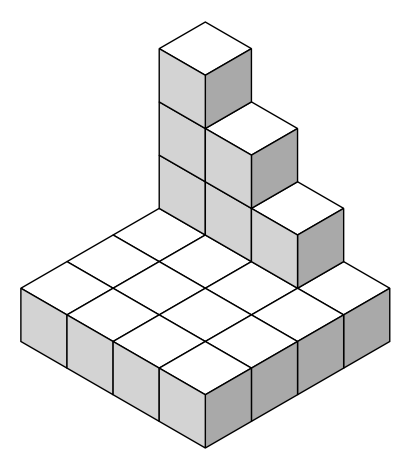

In [104]:
pp = PlanePartition([[4,3,2,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
pp.plot()

In [39]:
fd = tspp_fundamental_domain((5,5,5))
orbs = fd.rowmotion_orbits()
print(orbit_structure(orbs))
valid, invalid = 0, 0
for orb in orbs:
      for oi in orb:
          pp = oi_to_symmetric_plane_partition(oi)
          try:
              pp.is_TSPP()
              valid += 1
          except:
              invalid += 1

print("Valid: ", valid)
print("Invalid: ", invalid)

[2, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]


NameError: global name 'symmeterize_tableau' is not defined

In [32]:
valid = 0
invalid = 0

for orb in spp_rowmotion_orbits((3,3,3)):
    for oi in orb:
        pp = oi_to_plane_partition(oi)
        try:
            pp.is_SPP()
            valid += 1
        except:
            invalid += 1
print("Valid: ", valid)
print("Invalid: ", invalid)

NameError: global name 'symmeterize_tab' is not defined

In [139]:
len(list(tspp_iter((5,5,5))))

352

In [136]:
m = Matrix([[1,0,0],[1,1,0],[1,1,1]])

[1, 0, 0, 1, 1, 0, 1, 1, 1]

352

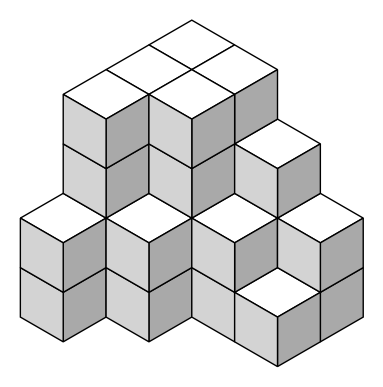

In [39]:
PlanePartition([[4,4,3,2],[4,4,2,1],[4,2,0,0],[2,0,0,0]]).plot()

Object `Poset.plot` not found.
{((0, 0), 0), ((1, 0), 0), ((0, 0), 1), ((0, 1), 0)}
Finite lattice containing 12 elements


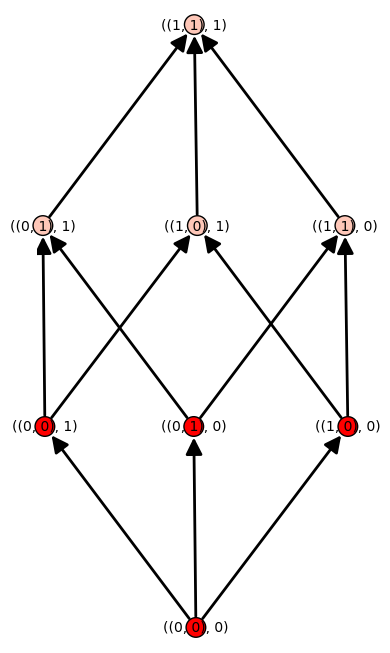

In [56]:
def plot_OI(myposet, OI):
    colors={}
    colors['red']=OI
    p=myposet.plot(vertex_colors=colors, figsize=10)
    return p
Poset.plot?

with_box = PlanePartition([[2, 1],
                           [1, 0]])
with_box_oi = plane_partition_to_chain_poset_oi(with_box)
print(with_box_oi)
print(product_of_3_chains_poset(3,2,2))
plot_OI(product_of_3_chains_poset(2,2,2), with_box_oi).show()


In [90]:
%matplotlib inline
P = Graphics()
p = spp_fundamental_domain((3,3,3))
ps = [point for point in p]
P += line3d([(0,0,0),(0,0,1)])
P += point3d(ps)
P.show(frame=False)

OSError: [Errno 2] No such file or directory

In [32]:
i = spp_iter((3,3,3))
next(i)
next(i)
next(i)
next(i)
next(i)


Plane partition [[3, 3, 3], [3, 3, 3], [3, 3, 0]]

In [19]:
Posets.ChainPoset?

In [20]:
product??